In [1]:
!pip install -q efficientnet

In [2]:
import tensorflow as tf
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D,MaxPooling2D, Activation, Flatten, Dropout, Dense
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
os.listdir("/kaggle/input/customized-whole-dataset/bd_plant_diseases_all_classes")

['All Classes']

In [3]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [4]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((75,75))
image_size = 0
directory_root = '/kaggle/input/customized-whole-dataset/bd_plant_diseases_all_classes'
width=75
height=75
depth=3

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list, directory_list = [], [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True:
                    directory_list.append(image_directory)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                else:
                    print(image_directory)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing EggPlant_Insect_Pest_Disease ...
[INFO] Processing Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing EggPlant_Wilt_Disease ...
[INFO] Processing Corn_healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Potato_Late_blight ...
[INFO] Processing Wheat_Yellow_Rust ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Corn_Northern_Leaf_Blight ...
[INFO] Processing Potato_healthy ...
[INFO] Processing EggPlant_Leaf_Spot_Disease ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Wheat_Brown_Rust ...
[INFO] Processing Cauliflower_Bacterial_spot_rot ...
[INFO] Processing Cauliflower_Healthy ...
[INFO] Processing Rice_Brown_spot ...
[INFO] Processing Cauliflower_Black_Rot ...
[INFO] Processing Wheat_Healthy ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Cauliflower_Downy_Mildew ...
[INFO] Processing Tomato_Target_Spot ...
[INFO] Processing Rice_Leaf

In [6]:
for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

[INFO] Processing EggPlant_Insect_Pest_Disease ...
[INFO] Processing Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing EggPlant_Wilt_Disease ...
[INFO] Processing Corn_healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Potato_Late_blight ...
[INFO] Processing Wheat_Yellow_Rust ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Corn_Northern_Leaf_Blight ...
[INFO] Processing Potato_healthy ...
[INFO] Processing EggPlant_Leaf_Spot_Disease ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Wheat_Brown_Rust ...
[INFO] Processing Cauliflower_Bacterial_spot_rot ...
[INFO] Processing Cauliflower_Healthy ...
[INFO] Processing Rice_Brown_spot ...
[INFO] Processing Cauliflower_Black_Rot ...
[INFO] Processing Wheat_Healthy ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Cauliflower_Downy_Mildew ...
[INFO] Processing Tomato_Target_Spot ...
[INFO] Processing Rice_Leaf_smut ...
[INFO] Processin

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cauliflower_Bacterial_spot_rot' 'Cauliflower_Black_Rot'
 'Cauliflower_Downy_Mildew' 'Cauliflower_Healthy'
 'Corn_Cercospora_leaf_spot_(Gray_leaf_spot)' 'Corn_Common_rust'
 'Corn_Northern_Leaf_Blight' 'Corn_healthy' 'EggPlant_Healthy_Leaf'
 'EggPlant_Insect_Pest_Disease' 'EggPlant_Leaf_Spot_Disease'
 'EggPlant_Mosaic_Virus_Disease' 'EggPlant_Small_Leaf_Disease'
 'EggPlant_White_Mold_Disease' 'EggPlant_Wilt_Disease'
 'Potato_Early_blight' 'Potato_Late_blight' 'Potato_healthy'
 'Rice_Bacterial_leaf_blight' 'Rice_Brown_spot' 'Rice_Healthy'
 'Rice_Leaf_smut' 'Tomato_Bacterial_spot' 'Tomato_Early_blight'
 'Tomato_Late_blight' 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites Two-spotted_spider_mite' 'Tomato_Target_Spot'
 'Tomato_Yellow_Leaf_Curl_Virus' 'Tomato_healthy' 'Tomato_mosaic_virus'
 'Wheat_Brown_Rust' 'Wheat_Healthy' 'Wheat_Yellow_Rust']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.15, random_state = 42)

[INFO] Spliting data to train, test


In [9]:
x_train.shape,x_test.shape

((25991, 75, 75, 3), (4587, 75, 75, 3))

In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [11]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0.0001,
                                     patience=10,
                                     mode="auto",
                                     verbose = 1)
]

In [12]:
len(image_list)

30578

In [13]:
def Res_Plot_Test_Save(name):
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    print("[INFO] Saving model")
    model.save(name)

In [14]:
# def display_training_curves(training, validation, yaxis):
#     ylabel = "{}".format(yaxis)
#     title = "{} vs. Epochs".format(yaxis)

#     fig = go.Figure()

#     fig.add_trace(
#         go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
#                name="Train"))

#     fig.add_trace(
#         go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
#                name="Val"))

#     fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
#     fig.show()

# display_training_curves(
#     history.history['accuracy'],
#     history.history['val_accuracy'],
#     'accuracy')

In [15]:
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32') 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

# Clear previous sessions
tf.keras.backend.clear_session()

# Define input shape and number of classes
input_shape = (75, 75, 3)  # Adjust according to your image size
n_classes = 35  # Set the number of classes

# Get the MobileNetV2 model for transfer learning
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global spatial average pooling layer
out = base_mobilenet.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)

# Create the complete model
model = Model(inputs=base_mobilenet.input, outputs=predictions)

# Optionally freeze the base layers
for layer in base_mobilenet.layers:
    layer.trainable = False

# Define learning rate and number of epochs
INIT_LR = 1e-4  # Adjust as necessary
EPOCHS = 20  # Set the number of epochs

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 38, 38,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 38, 38,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 38, 38,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 38, 38,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 38, 38,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 38, 38,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 38, 38,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 38, 38,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 39, 39,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 19, 19,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 19, 19,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 19, 19,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 19, 19,    │      2,304 │ block_1_depthwis

 Total params: 3,194,467 (12.19 MB)

 Trainable params: 936,483 (3.57 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# train the network
print("[INFO] training MobilenetV2 network...")
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=150
    )

[INFO] training MobilenetV2 network...
Epoch 1/150


I0000 00:00:1731562305.243914     102 service.cc:145] XLA service 0x7a92e80044b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731562305.243985     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731562305.243993     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/812 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.0278 - f1_m: 0.0000e+00 - loss: 0.7912 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

I0000 00:00:1731562309.564727     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


812/812 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.4211 - f1_m: 0.3370 - loss: 0.1231 - precision_m: 0.6475 - recall_m: 0.2477 - val_accuracy: 0.6782 - val_f1_m: 0.6754 - val_loss: 0.0484 - val_precision_m: 0.8005 - val_recall_m: 0.5871
Epoch 2/150
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5938 - f1_m: 0.5600 - loss: 0.0620 - precision_m: 0.7778 - recall_m: 0.4375 - val_accuracy: 0.6800 - val_f1_m: 0.6763 - val_loss: 0.0482 - val_precision_m: 0.8005 - val_recall_m: 0.5887
Epoch 3/150
812/812 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - accuracy: 0.6903 - f1_m: 0.6823 - loss: 0.0475 - precision_m: 0.8167 - recall_m: 0.5891 - val_accuracy: 0.7068 - val_f1_m: 0.7107 - val_loss: 0.0432 - val_precision_m: 0.7930 - val_recall_m: 0.6464
Epoch 4/150
812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - f1_m: 0.7407 - loss: 0.0423 - precision_m: 0.9091 - recall_m: 0.6250 - val_accuracy: 0.7070 - val_f1_m: 0.7133 - val_loss: 0.0430 - val_precision_m: 0.7944 - val_recall_m: 0.6

In [18]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.8384565114974976 
Loss:0.023745907470583916 
F1_score: 0.8405258059501648 
Precision: 0.8547938466072083 
Recall: 0.8271188139915466


In [34]:
import plotly.graph_objects as go
import numpy as np

def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)

    fig = go.Figure()

    # Use the length of training data to determine x-axis
    epochs = len(training)

    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs + 1), mode='lines+markers', y=training,
                   marker=dict(color="dodgerblue"), name="Train")
    )

    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs + 1), mode='lines+markers', y=validation,
                   marker=dict(color="darkorange"), name="Val")
    )

    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [46]:
history.history


{'accuracy': [0.5559921264648438,
  0.59375,
  0.6998728513717651,
  0.75,
  0.7305751442909241,
  0.84375,
  0.7514156699180603,
  0.53125,
  0.7575021982192993,
  0.5625,
  0.7664393782615662,
  0.8125,
  0.7795369625091553,
  0.8125,
  0.7846989631652832,
  0.78125,
  0.7882815003395081,
  0.78125,
  0.7951769828796387,
  0.78125,
  0.7972186803817749,
  0.875,
  0.8021880388259888,
  0.78125,
  0.8058862090110779,
  0.8125,
  0.8099695444107056,
  0.75,
  0.8117800951004028,
  0.875,
  0.814284086227417,
  0.84375,
  0.8175199627876282,
  0.78125,
  0.818752646446228,
  0.75,
  0.8241842985153198,
  0.78125,
  0.822296679019928,
  0.9375,
  0.8245310187339783,
  0.78125,
  0.826033353805542,
  0.78125,
  0.8337377905845642,
  0.75,
  0.832119882106781,
  0.8125,
  0.8314265012741089,
  0.8125,
  0.833082914352417,
  0.875,
  0.8349705338478088,
  0.84375,
  0.8367810845375061,
  0.78125,
  0.8378211855888367,
  0.90625,
  0.8375900387763977,
  0.75,
  0.8386686444282532,
  0.78125,

In [45]:
from IPython.display import display

def display_training_curves(history, yaxis):
    epochs = len(history.history[yaxis])
    epochs_range = np.arange(1, epochs + 1)
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=epochs_range, y=history.history[yaxis], mode='lines+markers', name="Train"))
    
    if 'val_' + yaxis in history.history:
        fig.add_trace(go.Scatter(x=epochs_range, y=history.history['val_' + yaxis], mode='lines+markers', name="Validation"))
    
    fig.update_layout(title=f'{yaxis} vs. Epochs', xaxis_title="Epochs", yaxis_title=yaxis, template="plotly_white")
    
    display(fig)  # Force display
    fig.show()  # Use fig.show() as fallback

# Displaying the curves
display_training_curves(history, 'accuracy')
display_training_curves(history, 'loss')
# display_training_curves(history, 'precision')
# display_training_curves(history, 'recall')
# display_training_curves(history, 'f1_m')


In [41]:
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy')
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss')
display_training_curves(
    history.history['precision_m'],
    history.history['val_precision_m'],
    'precision')
display_training_curves(
    history.history['recall_m'],
    history.history['val_recall_m'],
    'recall')
display_training_curves(
    history.history['f1_m'],
    history.history['val_f1_m'],
    'f1 score')

/kaggle/input/customized-whole-dataset/bd_plant_diseases_all_classes/All Classes/EggPlant_Mosaic_Virus_Disease/Mosaic-Virus-1-_jpg.rf.bd82b6c570b31d283ca4af86975961e1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


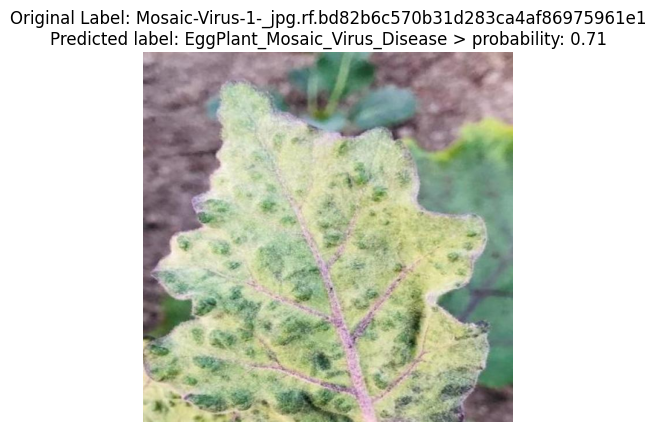

In [20]:
from random import randint

image_dir= "/kaggle/input/customized-whole-dataset/bd_plant_diseases_all_classes/All Classes/EggPlant_Mosaic_Virus_Disease/Mosaic-Virus-1-_jpg.rf.bd82b6c570b31d283ca4af86975961e1.jpg"
print(image_dir)
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
# print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

In [21]:
Res_Plot_Test_Save('MobilenetV2.h5')

[INFO] Calculating model accuracy
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8343 - f1_m: 0.8375 - loss: 0.0243 - precision_m: 0.8517 - recall_m: 0.8242
Test Accuracy: 83.84565114974976
[INFO] Saving model


In [22]:
model_size = os.path.getsize('MobilenetV2.h5')  # Size in bytes
model_size_mb = model_size / (1024 * 1024)  # Convert to MB
model_size_mb

19.83702850341797

In [38]:
import time
import numpy as np

# Convert x_test to a TensorFlow dataset for efficient batch processing
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(32)  # Adjust batch size as needed

# List to store inference times for each batch
inference_times = []

# Run inference on each batch in the dataset
for input_batch in test_dataset:
    start_time = time.time()
    _ = model(input_batch, training=False)  # Forward pass (inference)
    end_time = time.time()
    
    # Calculate and store time taken for this batch
    inference_times.append(end_time - start_time)

# Calculate average inference time per batch and per sample
average_inference_time_per_batch = np.mean(inference_times)
print(f"Average Inference Time per batch: {average_inference_time_per_batch:.6f} seconds")

# Per-sample inference time
batch_size = input_batch.shape[0]  # Assuming all batches are the same size
average_inference_time_per_sample = average_inference_time_per_batch / batch_size
print(f"Average Inference Time per sample: {average_inference_time_per_sample:.6f} seconds")


Average Inference Time per batch: 0.143409 seconds
Average Inference Time per sample: 0.013037 seconds
